# Data Mining and Decision Systems ACW
## October 2019
#### Student number: 201601628
#### Zak Catherall
<hr>

## Initial Work

#### Imports

In [1]:
%config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline

#### Global Vars

In [2]:
PATH = "data.csv"

#### Load Data

In [3]:
dfRaw = pd.read_csv(PATH)
dfRaw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 11 columns):
Random          1520 non-null float64
Id              1520 non-null int64
Indication      1517 non-null object
Diabetes        1518 non-null object
IHD             1520 non-null object
Hypertension    1517 non-null object
Arrhythmia      1520 non-null object
History         1518 non-null object
IPSI            1516 non-null float64
Contra          1520 non-null object
label           1517 non-null object
dtypes: float64(2), int64(1), object(8)
memory usage: 130.8+ KB


<b>Looking at the data dictionary it can be seen that the, "Random" attribute is unique and it's purpose is only for sorting, so it can be discarded to reduce the search space.</b>

However, first it should be checked that the data conforms to this assumption.

In [4]:
print(dfRaw["Random"].unique().shape[0])
print(dfRaw.shape[0])
diff = dfRaw["Random"].unique().shape[0]-dfRaw.shape[0]
print("Difference = " + str(abs(diff)))

1222
1520
Difference = 298


Based off the previous line of code, something is awry. Immediate assumptions are that some records are missing the data.

In [5]:
dfRaw[dfRaw["Random"].duplicated()]

,Random,Id,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label
1,0.602437,159284,TIA,no,no,no,no,no,70.0,60,NoRisk
2,0.602437,106066,A-F,no,yes,yes,no,no,95.0,40,Risk
10,0.678157,174588,CVA,no,yes,yes,yes,no,75.0,50,Risk
15,0.025356,219417,CVA,no,yes,yes,yes,no,90.0,100,Risk
19,0.065821,101248,ASx,yes,no,yes,no,no,80.0,80,Risk
...,...,...,...,...,...,...,...,...,...,...,...
1457,0.754513,293073,A-F,no,yes,no,yes,no,95.0,100,Risk
1459,0.735681,151183,CVA,no,no,no,no,no,75.0,90,NoRisk
1467,0.889219,202550,TIA,no,no,yes,no,no,77.0,20,NoRisk
1511,0.174637,284804,TIA,no,yes,no,no,no,73.0,30,NoRisk


The assumption was incorrect, and actually there are 298 duplicate records, which is equal to the difference between the number of unique values and expected.

<b>However, in this instance, the purpose of the feature is still unrelated to the label, so we'll remove it anyway.</b>

In [6]:
df = dfRaw.drop(["Random"], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 10 columns):
Id              1520 non-null int64
Indication      1517 non-null object
Diabetes        1518 non-null object
IHD             1520 non-null object
Hypertension    1517 non-null object
Arrhythmia      1520 non-null object
History         1518 non-null object
IPSI            1516 non-null float64
Contra          1520 non-null object
label           1517 non-null object
dtypes: float64(1), int64(1), object(8)
memory usage: 118.9+ KB


The next way we can reduce the search space is by reducing any binary features to 1 column and encoding as 1 or 0.

Again, we'll first check if each of the columns violate the data dictionary first.

In [7]:
binaryCols = ["Diabetes","IHD","Hypertension","Arrhythmia","History","label"]

for col in binaryCols:
    uniqueValues = df[col].unique()
    nUnique = uniqueValues.shape[0]
    if nUnique != 2:
        print(col + " column has " + str(nUnique) + " values - see below:")
        print(uniqueValues)

Diabetes column has 3 values - see below:
['no' 'yes' nan]
Hypertension column has 3 values - see below:
['yes' 'no' nan]
History column has 3 values - see below:
['no' 'yes' nan]
label column has 4 values - see below:
['NoRisk' 'Risk' 'Unknown' nan]


Having identified these inconsistencies, they should be measured to calculate the best approach between removing records with unexpected values and estimating them.

Of particular interest in the label column, since it provides our classification. Also note the lower case 'l' described as upper case in the dictionary.

In [8]:
colsWithNan = ["Diabetes","Hypertension","History"] # Excluding label as a special case.

for col in colsWithNan:
#     nNan = df[df[col] == np.nan]
#     print(col + " column has " + str(nNan) + " nan entries.")
#     print(df[df[col] == np.nan].shape)
    nYes = df[df[col] == "yes"].shape[0]
    nNo = df[df[col] == "no"].shape[0]        
    ynSum = nYes + nNo
    nNan = df[col].shape[0] - ynSum
    print(col + " column has " +str(nNan) + " nan entries.")

Diabetes column has 2 nan entries.
Hypertension column has 3 nan entries.
History column has 2 nan entries.


So absolute worse case, if nothing can be done about the data (and for the quantity it probably isn't worth it anyway), 7 records would be removed (before looking at the complications with the label column.

<b>For now I'll remove them and look into label.</b>

In [9]:
nRBefore = df.shape[0]
print(str(nRBefore) + " records before removing nan records.")
df.dropna(subset=colsWithNan, inplace=True)
nRAfter = df.shape[0]
print(str(nRAfter) + " records after removing nan records.")
nRemoved = nRBefore - nRAfter
print(str(nRemoved) + " records removed.")

1520 records before removing nan records.
1513 records after removing nan records.
7 records removed.


Repeat for label column.

In [10]:
nYes = df[df["label"] == "Risk"].shape[0]
nNo = df[df["label"] == "NoRisk"].shape[0]        
nUnknown = df[df["label"] == "Unknown"].shape[0]
print("label column has " +str(nUnknown) + " unknown entries.")
ynSum = nYes + nNo + nUnknown
nNan = df["label"].shape[0] - ynSum
print("label column has " +str(nNan) + " nan entries.")

label column has 2 unknown entries.
label column has 3 nan entries.


In [11]:
nRBefore = df.shape[0]
print(str(nRBefore) + " records before removing nan records.")
df.dropna(subset=["label"], inplace=True)
nRAfter = df.shape[0]
print(str(nRAfter) + " records after removing nan records.")
nRemoved = nRBefore - nRAfter
print(str(nRemoved) + " records removed.")

1513 records before removing nan records.
1510 records after removing nan records.
3 records removed.


Total of 10/1520 records lost to nan - acceptable. That just leaves the "Unknowns" of which there are 2 - they can be put to the side/dropped for now. It may be possible to estimate the values and/or calculate with the classifier model later as a test.

In [12]:
nRBefore = df.shape[0]
print(str(nRBefore) + " records before removing nan records.")

unknowns = df[df["label"] == "Unknown"]
for i in unknowns.index:
    print("Removing record at index " +  str(i))
    df.drop(index=i, inplace=True)
    
nRAfter = df.shape[0]
print(str(nRAfter) + " records after removing nan records.")
nRemoved = nRBefore - nRAfter
print(str(nRemoved) + " records removed.")

1510 records before removing nan records.
Removing record at index 475
Removing record at index 523
1508 records after removing nan records.
2 records removed.


<b>We can now re-run the recent code to confirm the edits we made have had the expected effect.</b>

<b>We've lost a total of 12 records out of the original 1520 (0.79%) leaving us with <u>1508</u>.</b>

Let's look at the ID field which should be mostly unique aside from multiple visits.

In [13]:
nDupeIDs = df[df["Id"].duplicated() == True].shape[0]

print("There are " + str(nDupeIDs) + " duplicate IDs.")

There are 0 duplicate IDs.


For current analysis (our snapshot) we don't need to be too concerned with the face that multiple ids/patient visits can occur.

In [14]:
df.describe(include='all')

,Id,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label
count,1508.000000,1505,1508,1508,1508,1508,1508,1504.000000,1508,1508
unique,NaN,5,2,2,2,2,2,NaN,41,2
top,NaN,A-F,no,no,no,no,no,NaN,100,NoRisk
freq,NaN,491,1433,794,782,1183,1485,NaN,241,1004
mean,188164.220822,NaN,NaN,NaN,NaN,NaN,NaN,78.830452,NaN,NaN
std,64451.543917,NaN,NaN,NaN,NaN,NaN,NaN,10.164507,NaN,NaN
min,78261.000000,NaN,NaN,NaN,NaN,NaN,NaN,35.000000,NaN,NaN
25%,136173.750000,NaN,NaN,NaN,NaN,NaN,NaN,73.000000,NaN,NaN
50%,191284.500000,NaN,NaN,NaN,NaN,NaN,NaN,77.000000,NaN,NaN
75%,244559.500000,NaN,NaN,NaN,NaN,NaN,NaN,85.000000,NaN,NaN


In [15]:
ynCols = ["Diabetes","IHD","Hypertension","Arrhythmia","History"]

df = pd.concat([df, pd.get_dummies(df[ynCols])], axis=1)
df = df.drop(columns=ynCols)

df = pd.concat([df, pd.get_dummies(df["label"])], axis=1)
df = df.drop(columns=["label", "NoRisk"])

df

,Id,Indication,IPSI,Contra,Diabetes_no,Diabetes_yes,IHD_no,IHD_yes,Hypertension_no,Hypertension_yes,Arrhythmia_no,Arrhythmia_yes,History_no,History_yes,Risk
0,218242,A-F,78.0,20,1,0,1,0,0,1,1,0,1,0,0
1,159284,TIA,70.0,60,1,0,1,0,1,0,1,0,1,0,0
2,106066,A-F,95.0,40,1,0,0,1,0,1,1,0,1,0,1
3,229592,TIA,90.0,85,1,0,1,0,0,1,1,0,1,0,1
4,245829,CVA,70.0,20,1,0,1,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,93406,A-F,76.0,60,1,0,0,1,1,0,1,0,1,0,0
1516,121814,A-F,90.0,75,1,0,1,0,0,1,0,1,1,0,1
1517,101754,TIA,75.0,20,1,0,1,0,0,1,1,0,1,0,0
1518,263836,A-F,70.0,45,1,0,0,1,1,0,1,0,1,0,0


We can further simplify the problem space by reducing dimensionality of binary features.

In [16]:
nCols = ["Diabetes_no","IHD_no","Hypertension_no","Arrhythmia_no","History_no"]
df = df.drop(columns=nCols)
df

,Id,Indication,IPSI,Contra,Diabetes_yes,IHD_yes,Hypertension_yes,Arrhythmia_yes,History_yes,Risk
0,218242,A-F,78.0,20,0,0,1,0,0,0
1,159284,TIA,70.0,60,0,0,0,0,0,0
2,106066,A-F,95.0,40,0,1,1,0,0,1
3,229592,TIA,90.0,85,0,0,1,0,0,1
4,245829,CVA,70.0,20,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1515,93406,A-F,76.0,60,0,1,0,0,0,0
1516,121814,A-F,90.0,75,0,0,1,1,0,1
1517,101754,TIA,75.0,20,0,0,1,0,0,0
1518,263836,A-F,70.0,45,0,1,0,0,0,0


In [17]:
df.describe(include="all")

,Id,Indication,IPSI,Contra,Diabetes_yes,IHD_yes,Hypertension_yes,Arrhythmia_yes,History_yes,Risk
count,1508.000000,1505,1504.000000,1508,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000
unique,NaN,5,NaN,41,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,A-F,NaN,100,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,491,NaN,241,NaN,NaN,NaN,NaN,NaN,NaN
mean,188164.220822,NaN,78.830452,NaN,0.049735,0.473475,0.481432,0.215517,0.015252,0.334218
std,64451.543917,NaN,10.164507,NaN,0.217469,0.499462,0.499821,0.411317,0.122594,0.471873
min,78261.000000,NaN,35.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,136173.750000,NaN,73.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,191284.500000,NaN,77.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,244559.500000,NaN,85.000000,NaN,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000


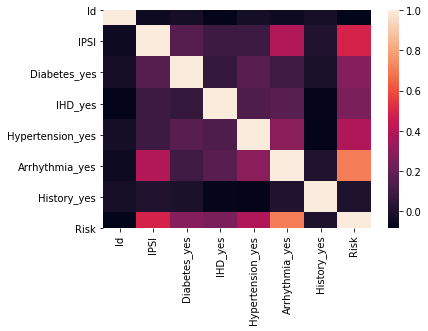

In [22]:
# label = df["label"]
# for col in df.columns.values:
#     if col == "label":
#         continue
#     else:
#         try:
#             print("Plot for " + col + " and label...")
#             sns.lmplot(x=col, y="label", data=df)            
#         except:
#             print("Failed : non-numeric")

# sns.lmplot(x="Arrhythmia_yes", y="Risk", data=df) 
# Calculate correlations
corr = df.corr()
 
# Heatmap
sns.heatmap(corr)

In [23]:
df = df.drop(columns=["History_yes", "Id"])

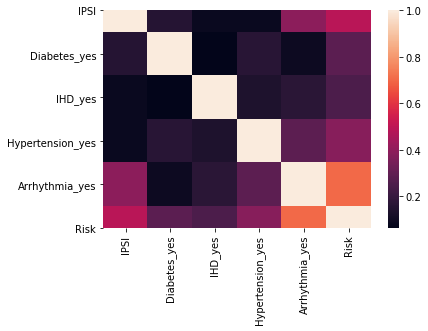

In [29]:
# Calculate correlations
corr = df.corr()
 
# Heatmap
sns.heatmap(corr)